In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from datetime import datetime

import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
## Fungsi ini untuk memperkecil dataset  dan mengubah tipe variable dalam penggunaan memory
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

### Membaca data yang akan dilatih

In [4]:
import pandas as pd
import numpy as np

df_train = reduce_memory_usage(pd.read_csv('../dataset/application_train.csv'))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [5]:
df_train.shape

(307511, 122)

In [6]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

In [7]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.0,306490.0,306490.0,306490.0,307510.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.0,265992.0,265992.0,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,NaN,-2994.202373,NaN,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.0,NaN,0.00

**Catatan Penting!**
1. Hasil deskripsi rata-rata bahwa data tidak seimbang
2. Masih banyak kolom NaN
3. Terdapat outlier pada kolom pendapatan

In [8]:
## Cek kolom NaN
nan_percent = (df_train.isna().sum() / len(df_train)) * 100

## Membuat dataframe dari kolom NaN
nan_percent_df = nan_percent.reset_index()
nan_percent_df.columns = ['Column', 'nan_percent']

## Mengurutkan datafarme berdasarkan kolom NaN
nan_percent_df = nan_percent_df.sort_values(by='nan_percent', ascending=False)

nan_percent_df.head(10)

,Column,nan_percent
48,COMMONAREA_AVG,69.872297
62,COMMONAREA_MODE,69.872297
76,COMMONAREA_MEDI,69.872297
84,NONLIVINGAPARTMENTS_MEDI,69.432963
70,NONLIVINGAPARTMENTS_MODE,69.432963
56,NONLIVINGAPARTMENTS_AVG,69.432963
86,FONDKAPREMONT_MODE,68.386172
54,LIVINGAPARTMENTS_AVG,68.354953
82,LIVINGAPARTMENTS_MEDI,68.354953
68,LIVINGAPARTMENTS_MODE,68.354953


**Catatan Insight!**
1. Nilai NaN masih banyak di dalam kumpulan data
2. Perlu diperhitungkan fitur yang penting untuk digunakan

### Analisis univariate calon nasabah pada kolom numerik

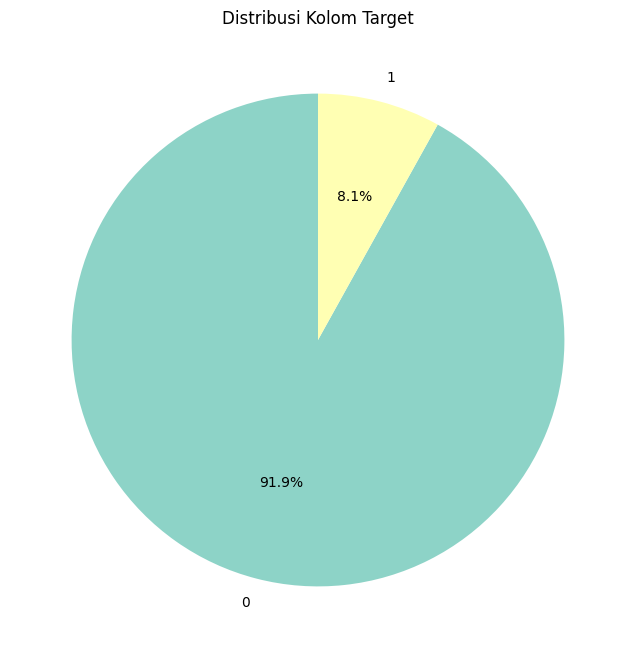

In [9]:
## Distribusi target
counts_target_column = df_train['TARGET'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts_target_column, labels=counts_target_column.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3'))
plt.title("Distribusi Kolom Target")
plt.show()

**Catatan Insight!** <br>
Berdasarkan hasil distribusi, teridentifikasi bahwa datanya tidak seimbang yaitu nilai target = 0 lebih unggul (91.9%) dibandingkan dengan nilai target = 1 jauh lebih rendah (8,1%).

In [10]:
## Melakukan implemeentasi fungsi untuk menunjukan distribusi variable kontinu dari variable target

def plot_target_histograms(df, numerical_column, target_column='TARGET'):
    df[numerical_column] = df[numerical_column].astype('float32')

    # Membagi dataset berdasarkan target
    target_0 = df[df[target_column] == 0]
    target_1 = df[df[target_column] == 1]

    # Membuat ukuran gambar
    plt.figure(figsize=(14, 10))

    # Membuat Plot histogram untuk target = 0
    plt.figure(figsize=(10,3))
    sns.histplot(target_0[numerical_column],kde=True, color='blue', alpha=0.5, label=f'{target_column} = 0')
    
    # Membuat Plot histogram untuk target = 1
    sns.histplot(target_1[numerical_column],kde=True, color='red', alpha=0.5 ,label=f'{target_column} = 0')
    
    plt.title(f'Histogram of {numerical_column}')
    plt.xlabel(numerical_column)
    plt.ylabel('Frequency')
    
    plt.legend()
    plt.show()

In [11]:
# filter pada kolom yang numerik saja
numerical_df = df_train.select_dtypes(include=['number'])

binary_columns = [col for col in numerical_df.columns if numerical_df[col].nunique() == 2]
non_binary_numerical_columns = [col for col in numerical_df.columns if col not in binary_columns]

non_binary_numerical_columns

['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MED

### Analisis Jumlah Kredit

<Figure size 1400x1000 with 0 Axes>

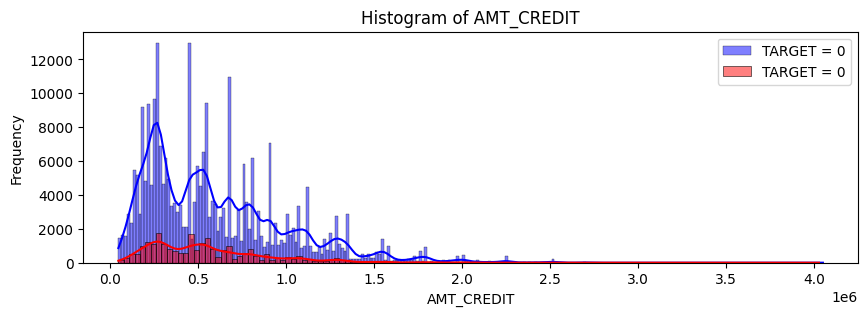

In [12]:
## Lakukan distribusi dari column AMT_CREDIT
plot_target_histograms(df_train, 'AMT_CREDIT')

**Catatan Insight!**
1. Sebagian besar jumlah kredit yang dilakukan yaitu dibawah 1,5 juta
2. Masih adanya outlier yang perlu di lakukan analisis kembali

<Figure size 1400x1000 with 0 Axes>

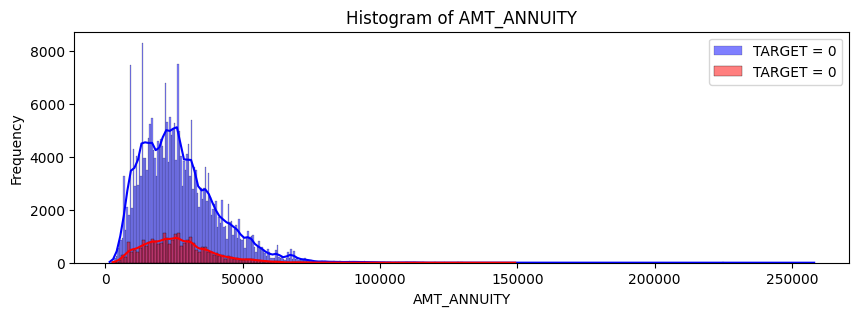

In [13]:
# Lakukan distribusi dari column AMT_ANNUNITY
plot_target_histograms(df_train, 'AMT_ANNUITY')

**Catatan Pengamatan!**
1. Berdasarkan hasil distribusi AMT_ANNUITY terlihat seperti AMT_CREDIT yang menunjukan adanya hubungan diatara keduanya.
2. Pada kolom AMT_ANNUITY masih terdapat oulier yang harus ditransformasikan

<Figure size 1400x1000 with 0 Axes>

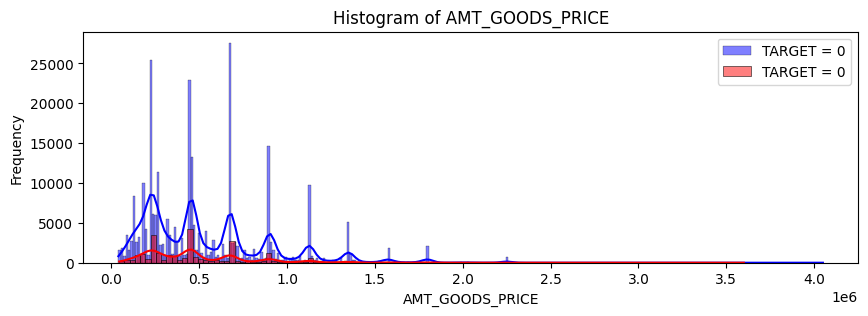

In [14]:
# Lakukan distribusi dari column AMT_GOODS_PRICE
plot_target_histograms(df_train, 'AMT_GOODS_PRICE')

**Catatan Pengamatan!** <br>
Berdasarkan hasil distribusi pada kolom AMT_GOODS_PRICE terlihat seperti AMT_CREDIT yang menunjukan ada hubungan diantara keduanya, yang harus dianalisis lebih lanjut

<Figure size 1400x1000 with 0 Axes>

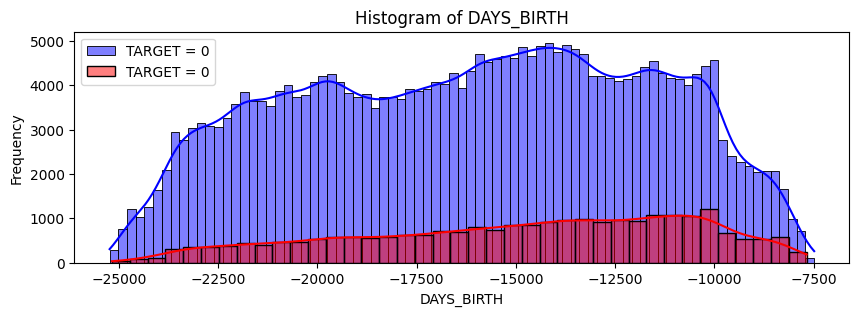

In [15]:
# Lakukan Distribusi dari column DAYS_BIRTH
plot_target_histograms(df_train, 'DAYS_BIRTH')

**Catatan Pengamatan!** <br>
Berdasarkan hasil analisis distribusi, usia muda merupakan hal yang penting karena orang yang lebih muda mungkin tidak mampu membayar hutang, menariknya orang yang lebih tua cenderung lebih mungkin untuk mendapatkan pembayaran kembali 

<Figure size 1400x1000 with 0 Axes>

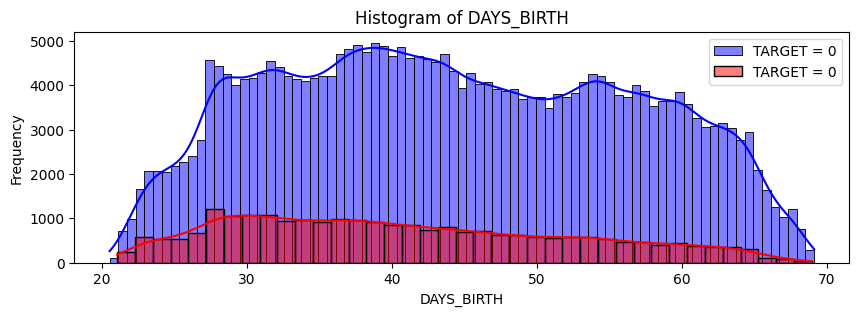

In [16]:
# Lakukan convert column DAYS_BIRTH ke tahun
df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH'] / -365
plot_target_histograms(df_train, 'DAYS_BIRTH')

**Catatan Insight!** <br>
1. Orang yang berusia 20:35 cenderung memiliki keyakinan lebih tinggi untuk tidak membayar kembali

2. Orang yang berusia 55:70 cenderung memiliki keyakinan dalam pembayaran kembali yang lebih tinggi.

<Figure size 1400x1000 with 0 Axes>

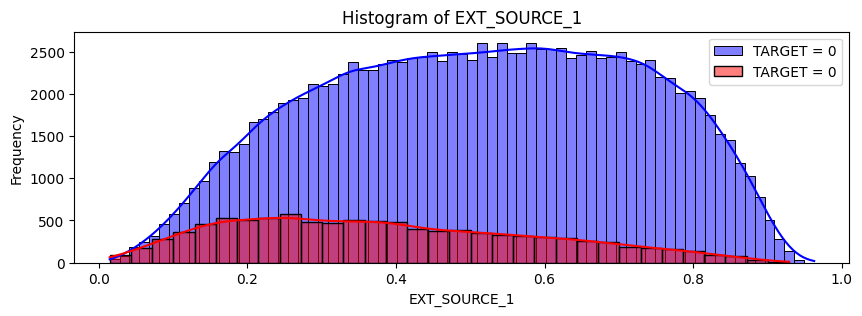

In [17]:
# Lakukan Distibusi dari column EXT_SOURCE_1
plot_target_histograms(df_train, 'EXT_SOURCE_1')

**Catatan Insight!** <br>
1. Skoring eksternal sumber pertama sangat berpengaruh dalam pemisahan
2. 1 kelas ini cenderung dapat meningkatkan skor yang memungkinkan pemabayaran kembali yang lebih tinggi

<Figure size 1400x1000 with 0 Axes>

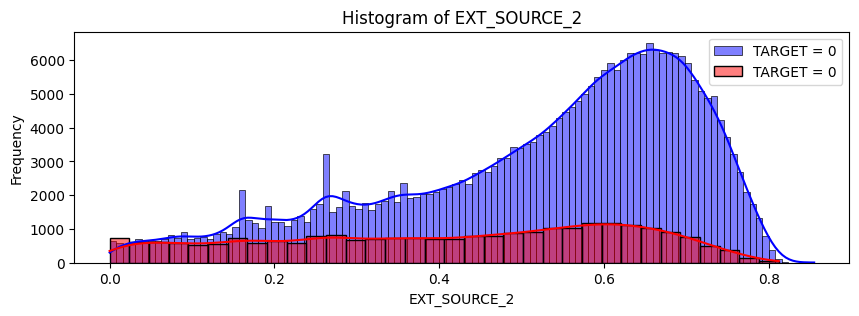

In [18]:
# Lakukan Distibusi dari column EXT_SOURCE_2
plot_target_histograms(df_train, 'EXT_SOURCE_2')

**Catatan Insight!** <br>
Skoring eksternal 2 ini sangat mempengaruhi dalam 2 kelas karena dapat meningkatkan skor berarti yang memugkinkan nasabah dapat melakukan pembayaran kembali yang lebih tinggi.

<Figure size 1400x1000 with 0 Axes>

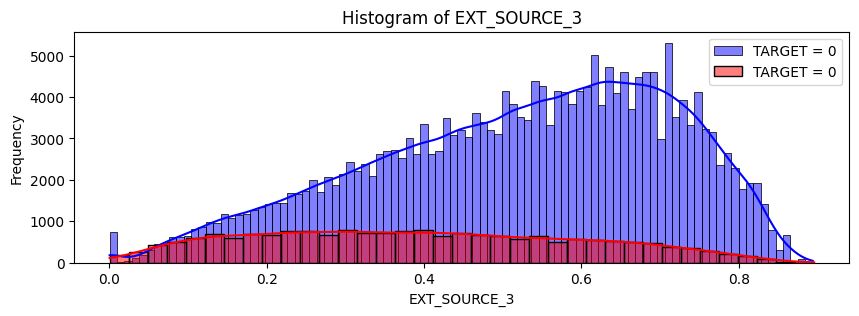

In [19]:
# lakukan Distribusi dari column EXT_SOURCE_3
plot_target_histograms(df_train, 'EXT_SOURCE_3')

**Catatan Insight!** <br>
Skoring eksternal 3 ini mungkin merupakan sebuah fitur paling penting dalam memisahkan kelas karena peningkatan skor berarti kemungkinan pembayaran kembali yang lebih tinggi

In [20]:
## Mengganti nilai positif menjadi 0 pada kolom 'DAYS_EMPLOYED'
column_name = 'DAYS_EMPLOYED'
df_train.loc[df_train[column_name] > 0, column_name] = 0

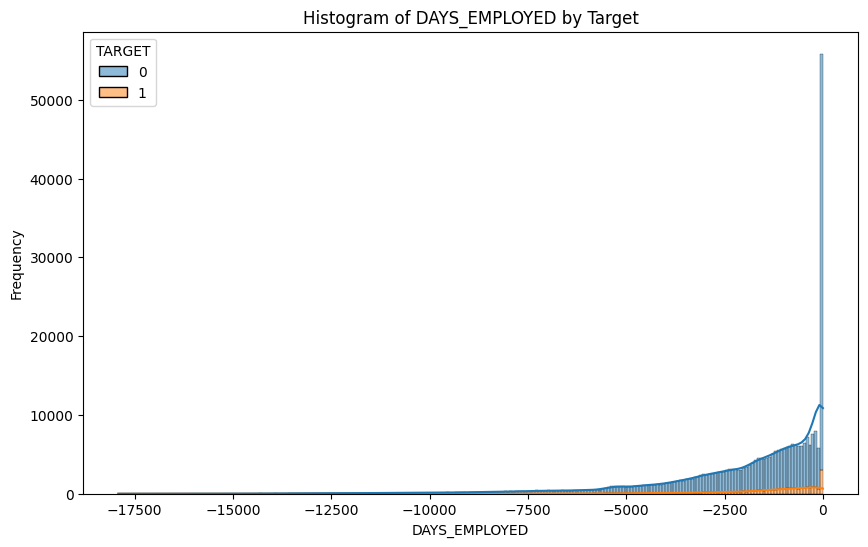

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='DAYS_EMPLOYED', hue='TARGET', multiple='stack', kde=True)
plt.title(f'Histogram of DAYS_EMPLOYED by Target')
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Frequency')
plt.show()

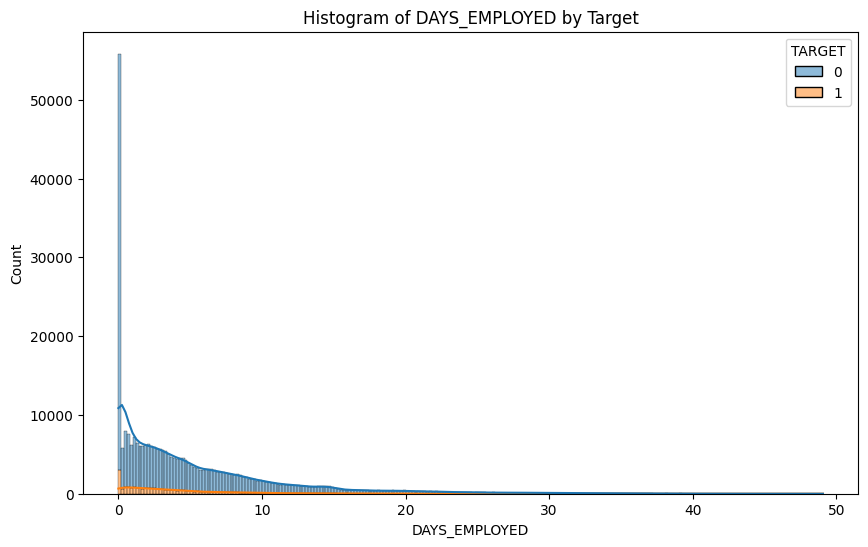

In [22]:
# Transformasikan kolom 'DAYS_EMPLOYED' menjadi tahun
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / -365
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='DAYS_EMPLOYED', hue='TARGET', multiple='stack', kde=True)
plt.title(f'Histogram of DAYS_EMPLOYED by Target')
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.show()

**Catatan Insight!** <br>
1. Sebagian besar nasabah home credit yang mengambil pinjaman adalah orang yang baru bekerja (90% dari mereka memiliki masa kerja antara 0 dan 10 tahun)
2. Dan feature ini merupakan hal penting karena nasabag home credit dilihat dari masa kerja yang lama cenderung membayar kembali hutangnya.

<Figure size 1400x1000 with 0 Axes>

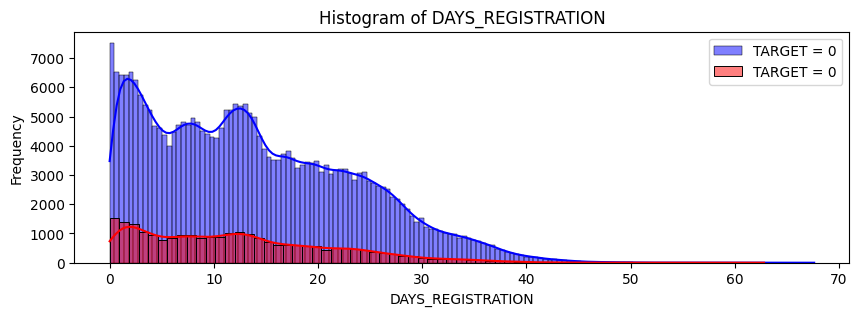

In [23]:
# Lakukan Distribusi dari column DAYS_REGISTRATION
df_train['DAYS_REGISTRATION'] = df_train['DAYS_REGISTRATION'] / -365
plot_target_histograms(df_train, 'DAYS_REGISTRATION')

**Catatan Insight!** <br>
Berdasarkan hasil analisis distribusi menunjukan bahwa nasabah yang melakukan pendaftaran yang lebih rendah maka cenderung mengambil jumlah pinjaman yang lebih tinggi 

### Analisis univariate calon nasabah pada kolom kategori

In [24]:
## Gunakan kolom kategori pada dataset train
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()+[col for col in df_train.columns if df_train[col].nunique() == 2 and df_train[col].isin([0, 1]).all()]
categorical_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCU

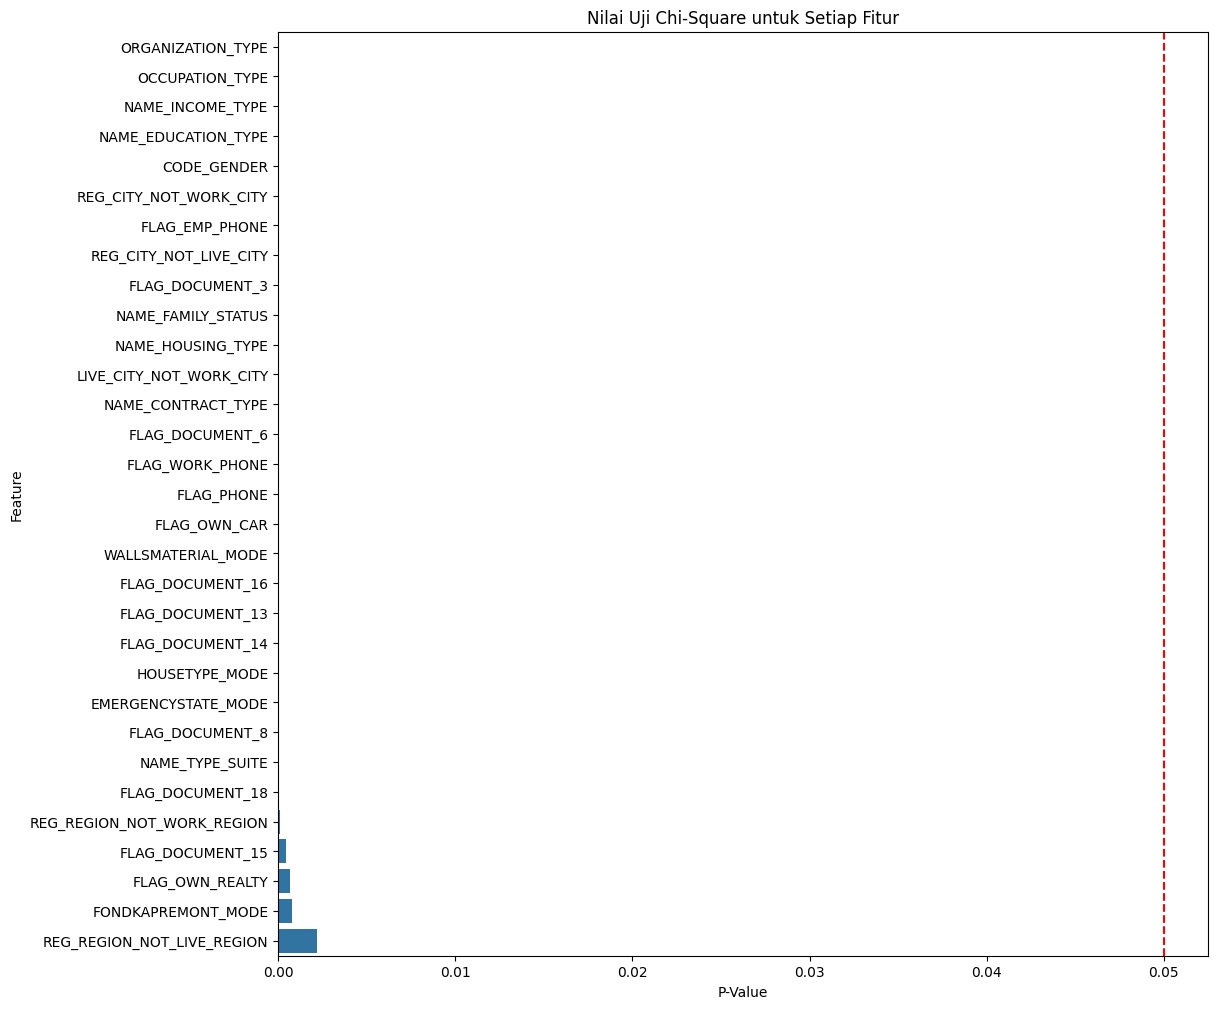

In [25]:
from scipy.stats import fisher_exact
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()

# Buat identifikasi dengan nilai 0 dan 1
binary_columns = [col for col in df_train.columns if df_train[col].nunique() == 2 and df_train[col].isin([0, 1]).all()]

# Lakukan List Pengkombinasian
relevant_columns = categorical_columns + binary_columns
relevant_columns.remove("TARGET")

# Save Hasilnya
chi2_results = []

for column in relevant_columns:
    # Buat tabel kontingensi
    contingency_table = pd.crosstab(df_train[column], df_train['TARGET'])
    
    # Lakukan uji chi-square
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Simpan hasilnya
    chi2_results.append((column, chi2, p))
    
# Buat DataFrame dari hasil uji chi-square
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'p-value'])

# Urutkan berdasarkan p-value
chi2_df = chi2_df.sort_values(by='p-value')

# Buatlah filter untuk p-value yang lebih kecil dari 0.05
significant_features = chi2_df[chi2_df['p-value'] < 0.01]
plt.figure(figsize=(12, 12))
sns.barplot(x='p-value', y='Feature', data=significant_features)
plt.axvline(x=0.05, color='red', linestyle='--')
plt.title('Nilai Uji Chi-Square untuk Setiap Fitur')
plt.xlabel('P-Value')
plt.ylabel('Feature')
plt.show()


### Visualisasi Kategori Organisasi Peminjam

In [26]:
## Buatlah fungsi penerapan yang telah di uji chi kuadrat yang berhubungan dengan kolom 'TARGET'
def catagorical_variables_target_relation(data, col1, col2 = 'TARGET'):
    
    # Hitung Jumlah nol dalam data
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    
    # Hitung data dengan cara pengelompokan
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Percent_not_repaying_loan'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    temp=temp.head()
    ind = np.arange(temp.shape[0])
    
    plt.figure(figsize=(10, 6))
    p1 = plt.bar(ind, temp['total'].values, color='blue')
    p2 = plt.bar(ind, temp[col2].values, color='red')
    
    plt.ylabel('Jenis Pinjaman')
    plt.title('Jumlah Pinjaman yang dilunasi VS yang tidak dilunasi')
    plt.xticks(ticks=ind, rotation=90, labels=list(temp[col1].values))
    plt.legend((p1[0], p2[0]), ('0 Target', '1 Target'))
    plt.show()
    print(temp.head(5))
    

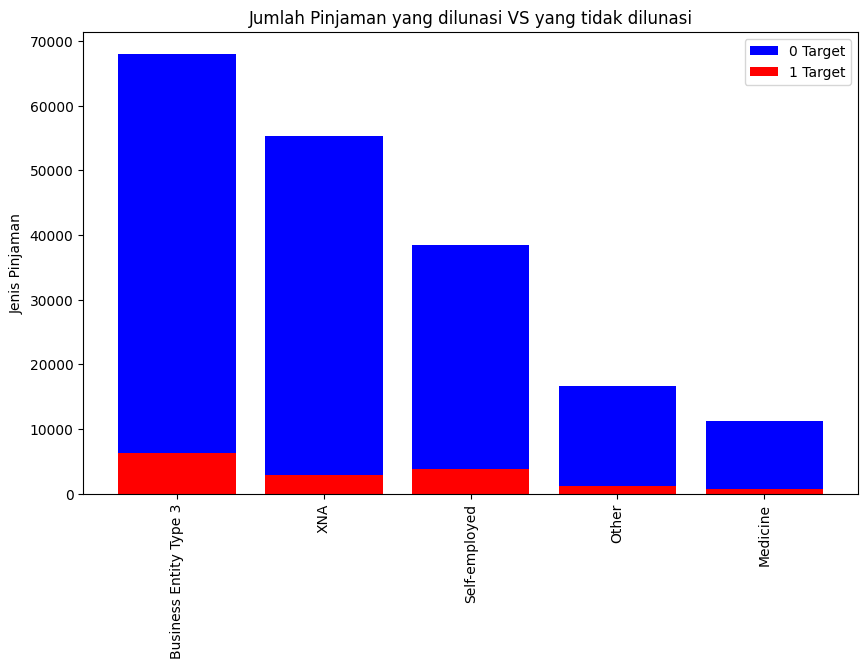

         ORGANIZATION_TYPE  TARGET  total  Percent_not_repaying_loan
5   Business Entity Type 3    6323  67992                   0.092996
57                     XNA    2990  55374                   0.053996
42           Self-employed    3908  38412                   0.101739
33                   Other    1275  16683                   0.076425
30                Medicine     737  11193                   0.065845


In [27]:
catagorical_variables_target_relation(df_train, "ORGANIZATION_TYPE", 'TARGET')

**Catatan Pengamatan!** <br>
1.  Profesi wiraswasta memiliki tingkat lebih tinggi sekitar 10% karena tidak membayar kembali pinjamannya.

2. Profesi bekerja dibidang kedokteran memiliki tingkat pembayaran utang yng lebih rendah yaitu sekitar 5%

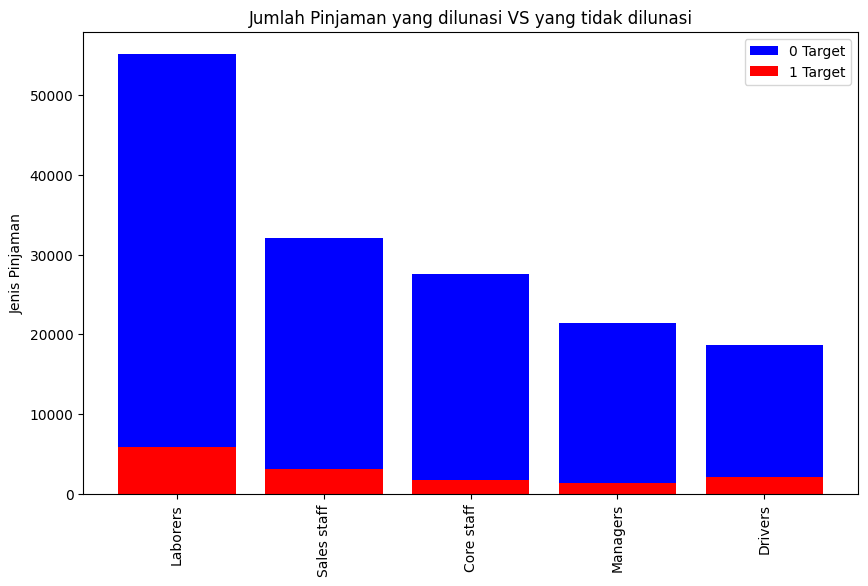

   OCCUPATION_TYPE  TARGET  total  Percent_not_repaying_loan
8         Laborers    5838  55186                   0.105788
14     Sales staff    3092  32102                   0.096318
3       Core staff    1738  27570                   0.063040
10        Managers    1328  21371                   0.062140
4          Drivers    2107  18603                   0.113261


In [28]:
catagorical_variables_target_relation(df_train, "OCCUPATION_TYPE", 'TARGET')

**Catatan Pengamatan!** <br>
Berdasarkan pengamatan, masyarakat yang berprofesi sebagai buruh atau supir cenderung memiliki tingkat kegagalan membayar utang yang lebih tinggi sebesar 11%, sedangkan profesi manager dan staff memiliki tingkat kegagalan membayar utang yang lebih rendah yaitu sebesar 5%.


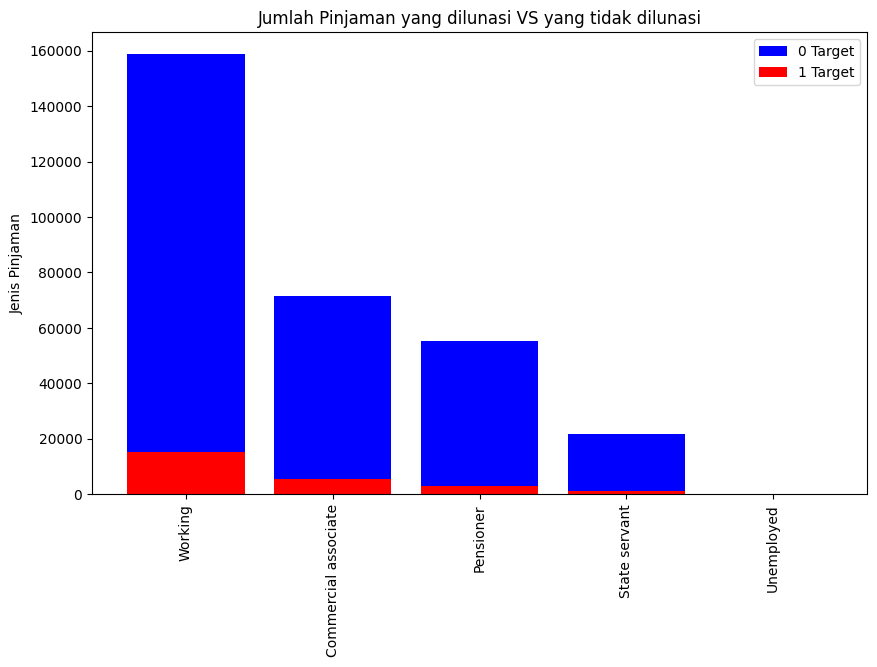

       NAME_INCOME_TYPE  TARGET   total  Percent_not_repaying_loan
7               Working   15224  158774                   0.095885
1  Commercial associate    5360   71617                   0.074843
3             Pensioner    2982   55362                   0.053864
4         State servant    1249   21703                   0.057550
6            Unemployed       8      22                   0.363636


In [29]:
catagorical_variables_target_relation(df_train, "NAME_INCOME_TYPE", 'TARGET')

**Catatan Pengamatan!** <br>
Berdasarkan pengamatan, jenis pendapatan pada nasabah yang bekerja memiliki tingkat membayar pinjaman perusahaan yang lebih tinggi sekitar 9,5%

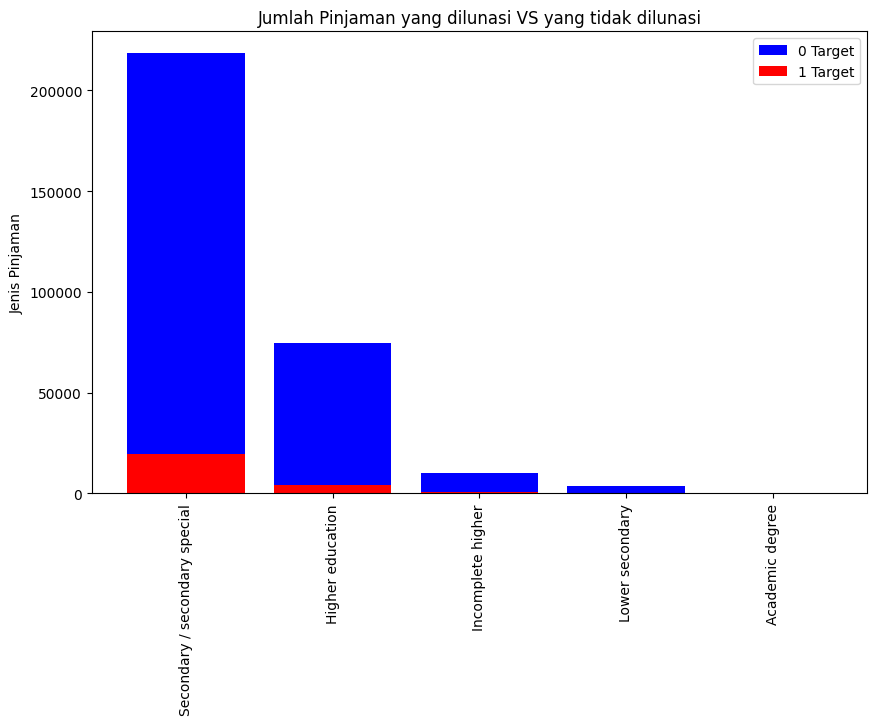

             NAME_EDUCATION_TYPE  TARGET   total  Percent_not_repaying_loan
4  Secondary / secondary special   19524  218391                   0.089399
1               Higher education    4009   74863                   0.053551
2              Incomplete higher     872   10277                   0.084850
3                Lower secondary     417    3816                   0.109277
0                Academic degree       3     164                   0.018293


In [30]:
catagorical_variables_target_relation(df_train, "NAME_EDUCATION_TYPE", 'TARGET')

**Catatan Pengamatan!** <br>
Berdasarkan analisis tingkat pendidikan tinggi dan memiliki gelar akademis memiliki presentase lebih kecil untuk tidak membayar pinjaman.Meskipun masyarakat dengan pendidikan menengah pertama memiliki kemungkinan lebih tinggi untuk tidak membayar kembali pinjamannya.Sebagian besar orang yang mengambil pinjaman di HomeCredit statusnya adalah siswa yang sekolah menengah timur

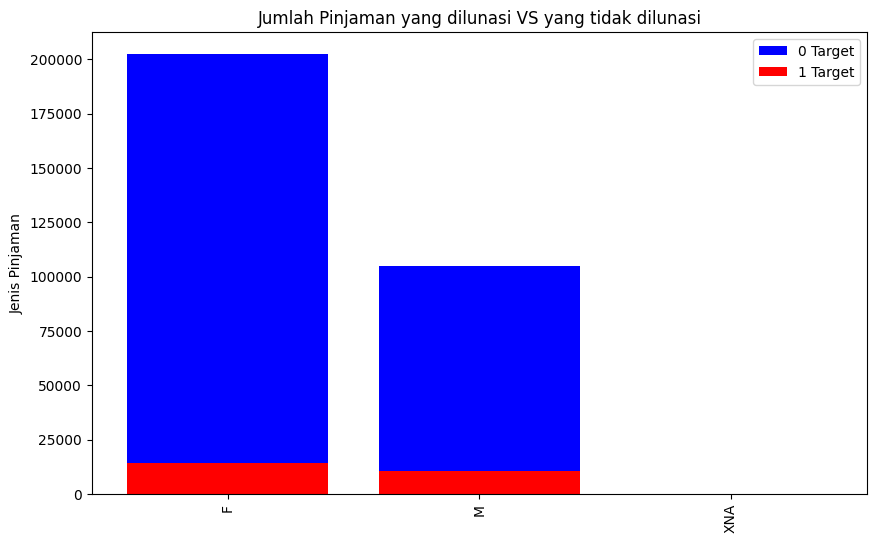

  CODE_GENDER  TARGET   total  Percent_not_repaying_loan
0           F   14170  202448                   0.069993
1           M   10655  105059                   0.101419
2         XNA       0       4                   0.000000


In [31]:
catagorical_variables_target_relation(df_train, 'CODE_GENDER', 'TARGET')

**Catatan Pengamatan!** <br>
Berdasarkan analisis kategori jenis kelamin peminjam, laki-laki cenderung paling memungkinkan dalam melunasi pinjamannya dibandingkan perempuan.Sedangkan perempuan cenderung berhutang dua kali lebih sering dibandingkan laki-laki.

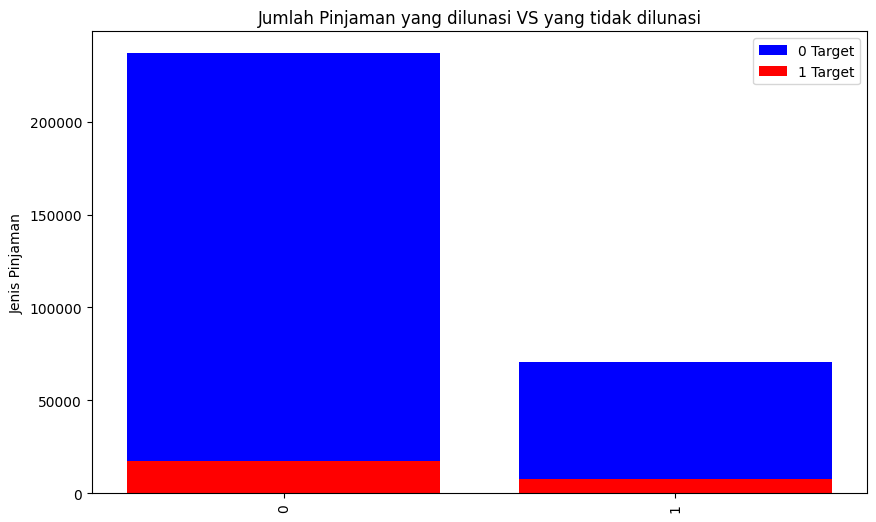

   REG_CITY_NOT_WORK_CITY  TARGET   total  Percent_not_repaying_loan
0                       0   17305  236644                   0.073127
1                       1    7520   70867                   0.106114


In [32]:
catagorical_variables_target_relation(df_train, "REG_CITY_NOT_WORK_CITY", 'TARGET')

**Catatan Pengamatan!** <br>
Berdasarkan analisis kategori **Tidak Bekerja di Kota** lebih besar kemungkinannya untuk tidak melunasi pinjamannya

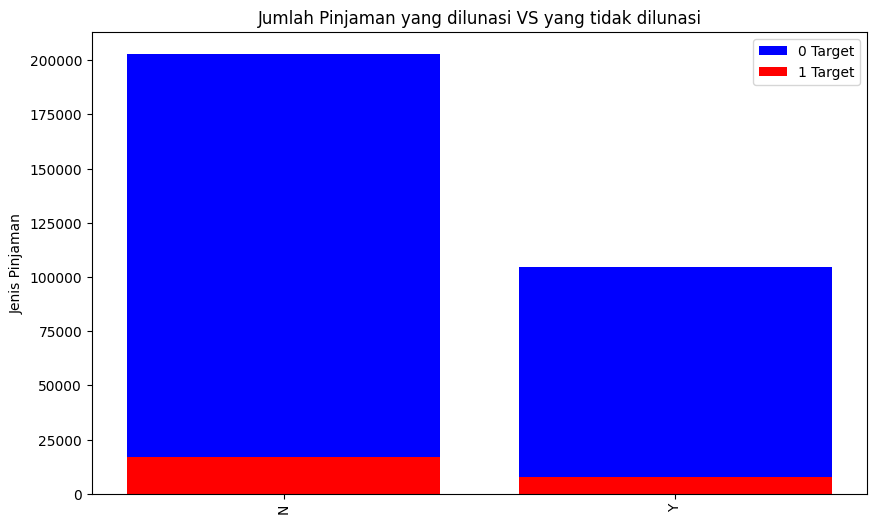

  FLAG_OWN_CAR  TARGET   total  Percent_not_repaying_loan
0            N   17249  202924                   0.085002
1            Y    7576  104587                   0.072437


In [33]:
catagorical_variables_target_relation(df_train, "FLAG_OWN_CAR", 'TARGET')

**Catatan Insight!** <br>
Berdasarkan analisis nasabah yang mengambil pinjaman lebih banyak tidak memiliki mobil, sedangkan yang memiliki mobil cenderung lebih cepat dalam melakukan pelunasan atau pembayaran kembali.

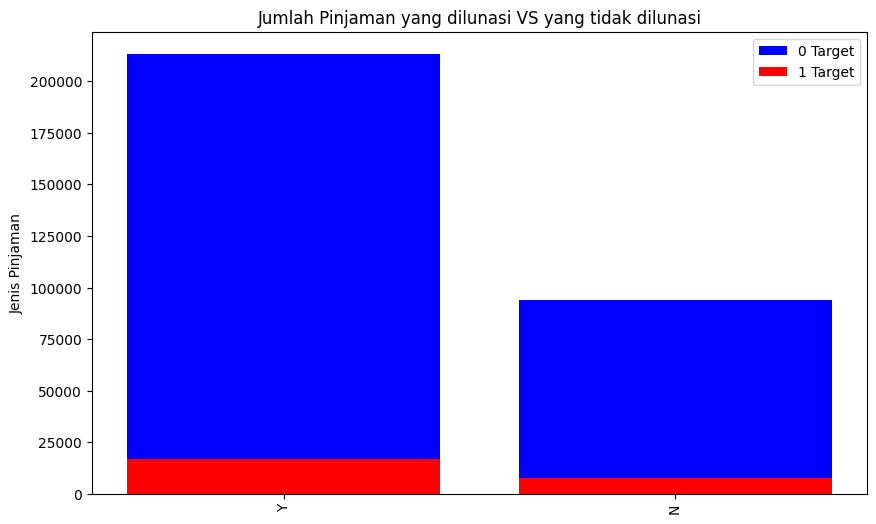

  FLAG_OWN_REALTY  TARGET   total  Percent_not_repaying_loan
1               Y   16983  213312                   0.079616
0               N    7842   94199                   0.083249


In [34]:
catagorical_variables_target_relation(df_train, 'FLAG_OWN_REALTY')

**Catatan Insight!** <br>
Berdasarkan analisis nasabah yang mengambil pinjaman cenderung memiliki aset nyata (memiliki properti atau aset yang lain).  Sedangkan yang tidak memiliki aset nyata kemungkinan tidak melakukan pelunasan 

### Analisis Bivariate pada Kolom numerik

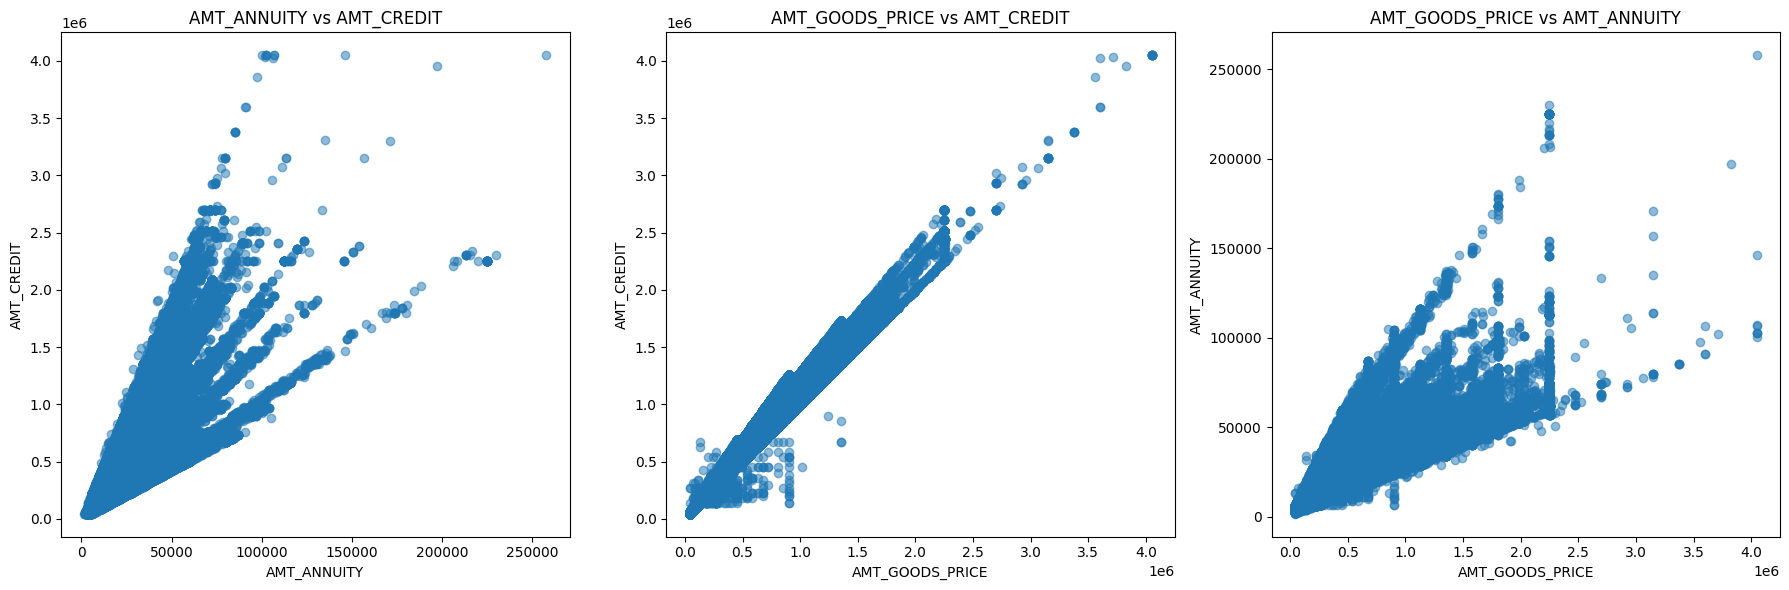

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Buat Scatter Plot AMT_ANNUITY VS AMT_CREDIT
axes[0].scatter(df_train['AMT_ANNUITY'], df_train['AMT_CREDIT'], alpha=0.5)
axes[0].set_title('AMT_ANNUITY vs AMT_CREDIT')
axes[0].set_xlabel('AMT_ANNUITY')
axes[0].set_ylabel('AMT_CREDIT')

# Buat Scatter Plot AMT_GOODS_PRICE VS AMT_CREDIT
axes[1].scatter(df_train['AMT_GOODS_PRICE'], df_train['AMT_CREDIT'], alpha=0.5)
axes[1].set_title('AMT_GOODS_PRICE vs AMT_CREDIT')
axes[1].set_xlabel('AMT_GOODS_PRICE')
axes[1].set_ylabel('AMT_CREDIT')

# Buat Scatter Plot AMT_GOODS_PRICE VS AMT_ANNUITY
axes[2].scatter(df_train['AMT_GOODS_PRICE'], df_train['AMT_ANNUITY'], alpha=0.5)
axes[2].set_title('AMT_GOODS_PRICE vs AMT_ANNUITY')
axes[2].set_xlabel('AMT_GOODS_PRICE')
axes[2].set_ylabel('AMT_ANNUITY')

plt.tight_layout()
plt.show()

**Catatan Insight!** <br>
Berdasarkan hasil korelasi dari ketiga fitur sangat berkorelasi tandanya masuk data fitur tersebut masih saling berkaitan

In [36]:
## Lakukan Analisis Mendalam mengapa perempuan akan membayar lebih sedikit dibandingkan laki-laki
def plot_box_with_two_categorical(df, numerical_column, cat_col1, cat_col2):
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=df, x=cat_col1, y=numerical_column, hue=cat_col2)
    plt.title(f'Box Plot of {numerical_column} with respect to {cat_col1} and {cat_col2}')
    plt.xlabel(cat_col1)
    plt.ylabel(numerical_column)
    plt.legend(title=cat_col2)
    plt.show()

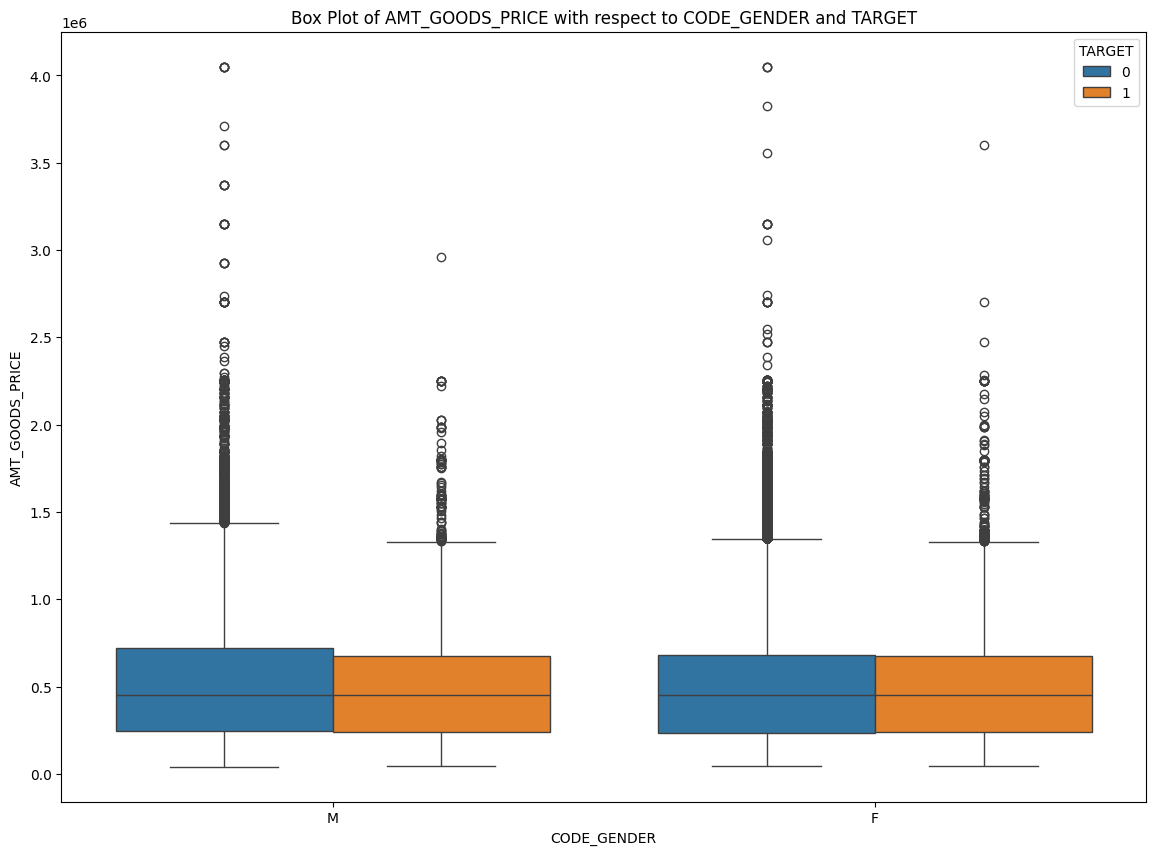

In [37]:
# Hapus Kategori XNA (karena Outlier)
df_train["CODE_GENDER"]=df_train["CODE_GENDER"].str.replace("XNA","M")
plot_box_with_two_categorical(df_train, "AMT_GOODS_PRICE", "CODE_GENDER", "TARGET")

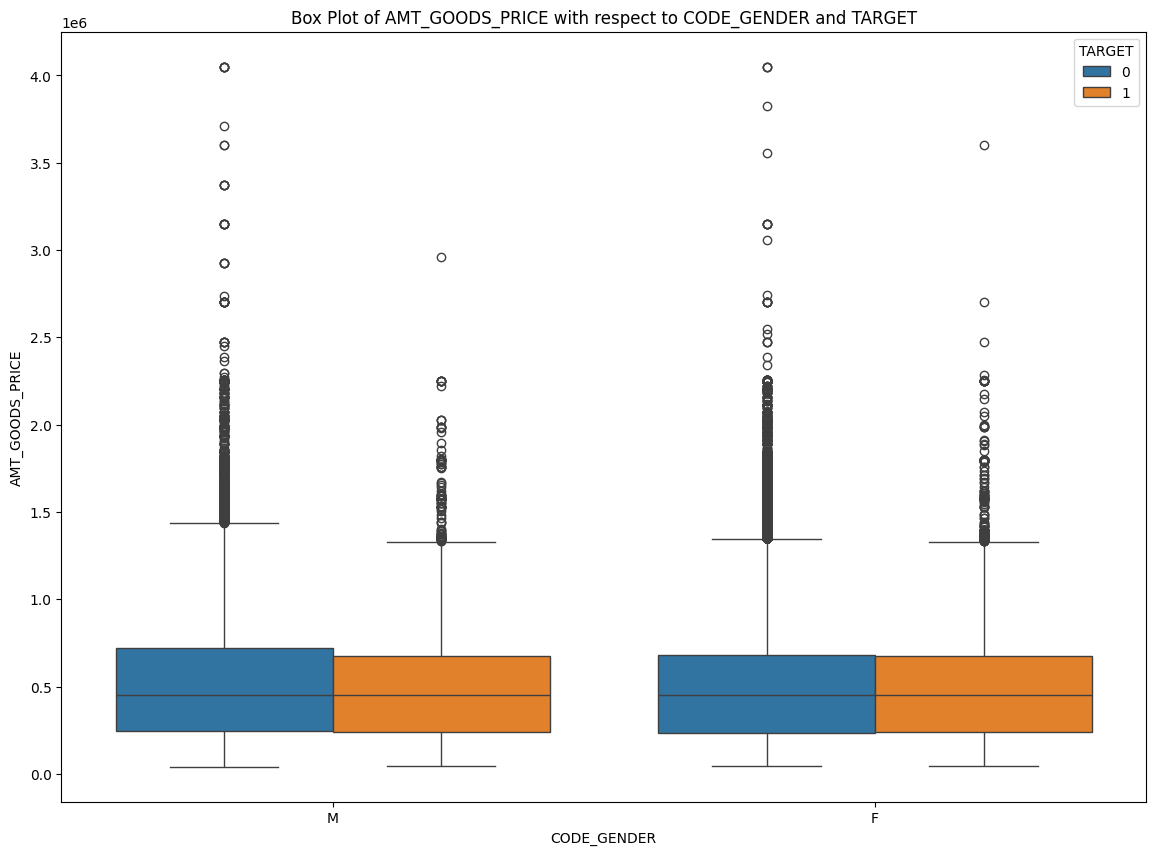

In [38]:
df_train["CODE_GENDER"]=df_train["CODE_GENDER"].str.replace("XNA","M")
plot_box_with_two_categorical(df_train, "AMT_GOODS_PRICE", "CODE_GENDER", "TARGET")

**Catatan Insight!** <br>
Wawasan :
1. Saya perkirakan perempuan lebih banyak yang melakukan mangkir dibandingkan laki-laki karena mereka membeli lebih banyak barang. Namun hal tersebut salah dan alasan yang sebenarnya adalah bahwa pendapatan tahunan laki-laki lebih tinggi dibandingkan perempuan sehingga membuat perempuan lebih banyak melakukan mangkir dibandingkan laki-laki.

2. Total pendapatan laki-laki yang mangkir lebih sedikit daripada yang tidak mangkir yang menjadikan fitur AMT_INCOME_TOTAL ini penting

### Credit Card Balance Information

In [39]:
credit_card_df = reduce_memory_usage(pd.read_csv('../dataset/credit_card_balance.csv'))

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


In [41]:
credit_card_df.shape

(3840312, 23)

In [43]:
credit_card_df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


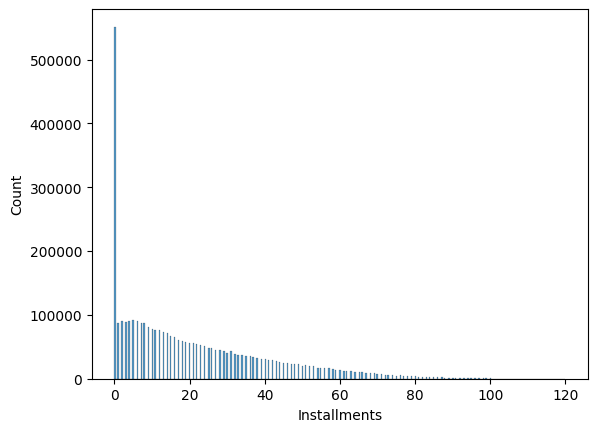

In [44]:
credit_card_df['CNT_INSTALEMENT_MATURE_CUM'] = credit_card_df['CNT_INSTALMENT_MATURE_CUM'].astype(np.float64)
sns.histplot(x='CNT_INSTALEMENT_MATURE_CUM', data=credit_card_df)
plt.xlabel('Installments')
plt.show()